Import Library


In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

Load Dataset

In [71]:
url = 'https://raw.githubusercontent.com/kucingku-capstone/machine-learning/2287f89cf2f09bbf23dd71312985b22961f96762/dataset/merged_dataset_with_rating.csv'
df = pd.read_csv(url)
df

,cat_id,cat_name,cat_age,cat_gender,cat_size,cat_breed,cat_image,cat_rating,user_id,user_first_name,user_last_name,user_gender,user_age
0,0,trisie beiji,Adult,female,Large,local,Trisie Beiji.jpg,1,0,shelia,Mahoney,Male,68
1,1,trisi sukmajaya,Young,female,Large,local,Trisi Sukmajaya.jpg,4,1,jo,Rivers,Female,37
2,2,uli,Young,female,Large,local,Uli.jpg,0,2,sheryl,Lowery,Female,53
3,3,chika,Adult,female,Large,local,Chika.jpg,5,3,whitney,Hooper,Male,54
4,4,cookies,Young,female,Large,local,Cookies.jpg,4,4,lindsey,Rice,Female,68
5,5,merdeka,Adult,female,Large,local,Merdeka,0,5,sherry,Caldwell,Male,19
6,6,paper,Adult,female,Large,local,Paper,0,6,ernest,Hoffman,Male,26
7,7,biru,Young,female,Large,local,Biru.jpg,0,7,doris,Andersen,Male,44
8,8,sikunyit,Adult,female,Large,local,Sikunyit.jpg,1,8,cheryl,Mays,Male,22
9,9,kuro fe ui,Young,female,Large,local,Kuro FE UI.jpg,3,9,harry,Mitchell,Male,63


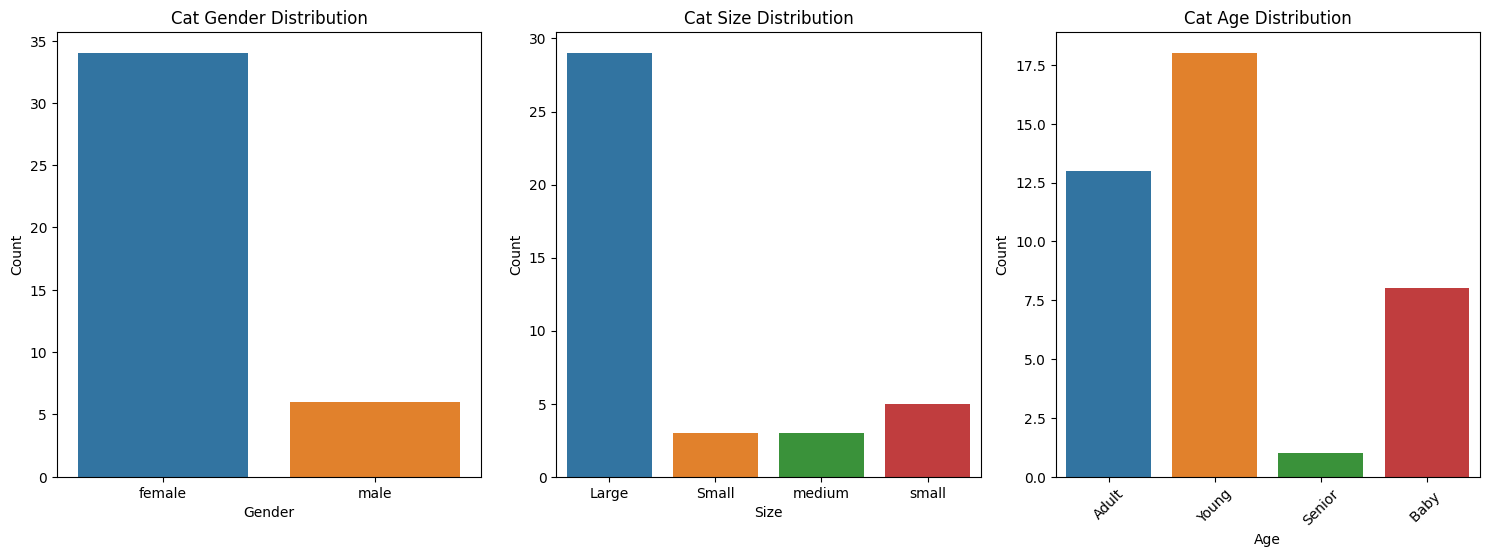

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize 3 cat category in dateset
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.countplot(x='cat_gender', data=df)
plt.title('Cat Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.subplot(2, 3, 2)
sns.countplot(x='cat_size', data=df)
plt.title('Cat Size Distribution')
plt.xlabel('Size')
plt.ylabel('Count')

plt.subplot(2, 3, 3)
sns.countplot(x='cat_age', data=df)
plt.title('Cat Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

plt.tight_layout()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


Text(0, 0.5, 'Count')

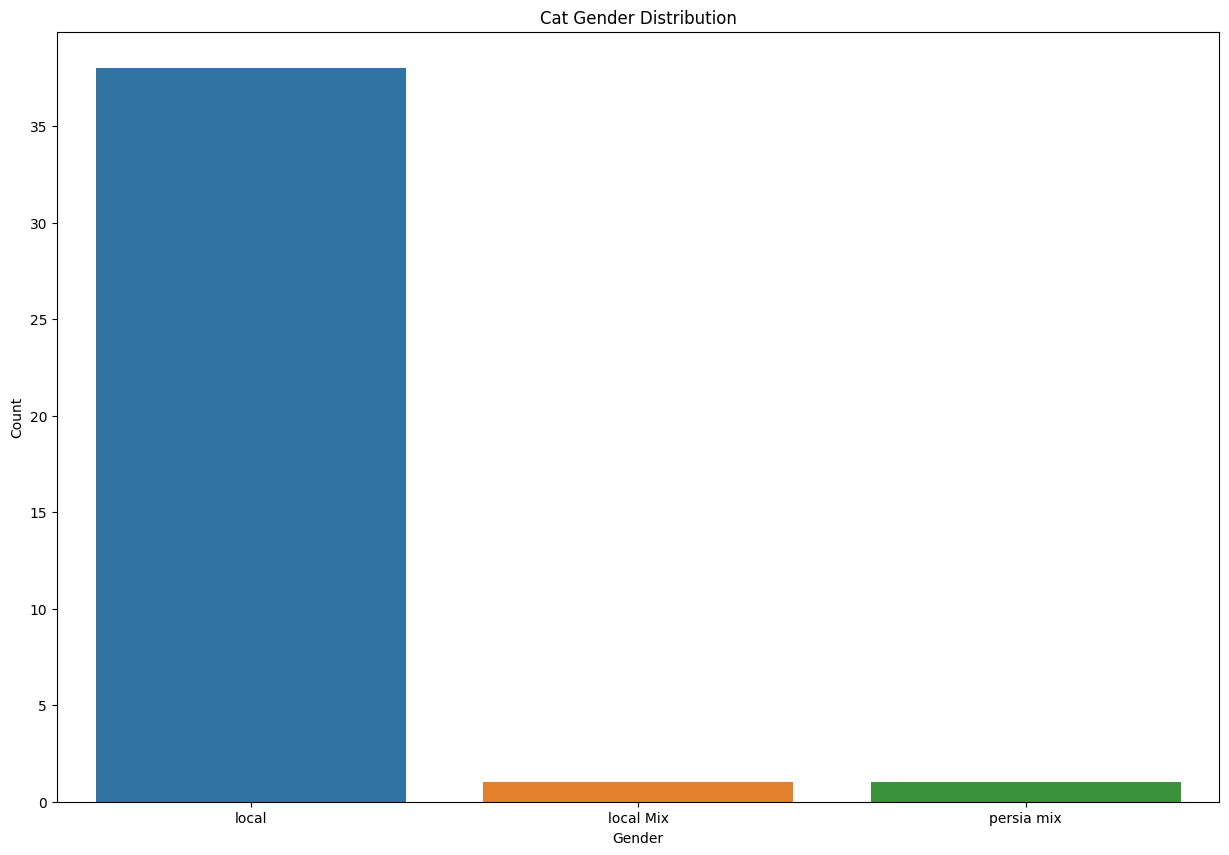

In [ ]:
# Visualize cat breed in dataset
plt.figure(figsize=(15, 10))

sns.countplot(x='cat_breed', data=df)
plt.title('Cat Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

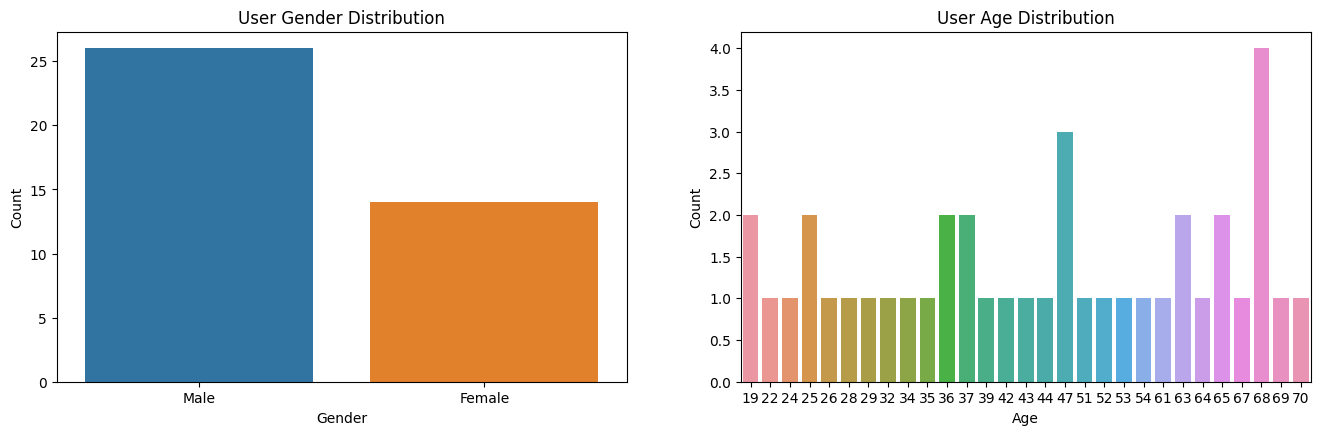

In [ ]:
# Visualize 2 user category in dateset
plt.figure(figsize=(25, 10))

plt.subplot(2, 3, 1)
sns.countplot(x='user_gender', data=df)
plt.title('User Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.subplot(2, 3, 2)
sns.countplot(x='user_age', data=df)
plt.title('User Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

### Data preprocessing

In [72]:
user_gender_encoder = LabelEncoder()
user_age_encoder = LabelEncoder()
cat_gender_encoder = LabelEncoder()
cat_size_encoder = LabelEncoder()
cat_age_encoder = LabelEncoder()
cat_breed_encoder = LabelEncoder()


In [73]:
df['user_gender'] = user_gender_encoder.fit_transform(df['user_gender'].astype(str)).astype(float)
df['user_age'] = user_age_encoder.fit_transform(df['user_age'].astype(str)).astype(float)
df['cat_gender'] = cat_gender_encoder.fit_transform(df['cat_gender'].astype(str)).astype(float)
df['cat_size'] = cat_size_encoder.fit_transform(df['cat_size'].astype(str)).astype(float)
df['cat_age'] = cat_age_encoder.fit_transform(df['cat_age'].astype(str)).astype(float)
df['cat_breed'] = cat_breed_encoder.fit_transform(df['cat_breed'].astype(str)).astype(float)

In [74]:
encoders = {
    'user_gender_encoder': user_gender_encoder,
    'user_age_encoder': user_age_encoder,
    'cat_gender_encoder': cat_gender_encoder,
    'cat_size_encoder': cat_size_encoder,
    'cat_age_encoder': cat_age_encoder,
    'cat_breed_encoder' : cat_breed_encoder
}

np.save('cat_encoder.npy', encoders)

### Split the dataset into training and testing

In [75]:
train_df, test_df = train_test_split(df, test_size=0.4, random_state=42)

### Create the collaborative filtering model using TensorFlow

In [77]:
num_user_genders = len(user_gender_encoder.classes_)
num_user_ages = len(user_age_encoder.classes_)
num_cat_genders = len(cat_gender_encoder.classes_)
num_cat_sizes = len(cat_size_encoder.classes_)
num_cat_ages = len(cat_age_encoder.classes_)
num_cat_breeds = len(cat_breed_encoder.classes_)

In [78]:
embedding_size = 50

In [79]:
# Define input layers
user_gender_input = Input(shape=(1,), name='user_gender_input')
user_age_input = Input(shape=(1,), name='user_age_input')
cat_gender_input = Input(shape=(1,), name='cat_gender_input')
cat_size_input = Input(shape=(1,), name='cat_size_input')
cat_age_input = Input(shape=(1,), name='cat_age_input')
cat_breed_input = Input(shape=(1,), name='cat_breed_input')

In [80]:
# Define embedding layers
user_gender_embedding = Embedding(input_dim= num_user_genders, output_dim=embedding_size, input_length=1)(user_gender_input)
user_age_embedding = Embedding(input_dim= num_user_ages, output_dim=embedding_size, input_length=1)(user_age_input)
cat_gender_embedding = Embedding(input_dim= num_cat_genders, output_dim=embedding_size, input_length=1)(cat_gender_input)
cat_size_embedding = Embedding(input_dim= num_cat_sizes, output_dim=embedding_size, input_length=1)(cat_size_input)
cat_age_embedding = Embedding(input_dim= num_cat_ages, output_dim=embedding_size, input_length=1)(cat_age_input)
cat_breed_embedding = Embedding(input_dim= num_cat_breeds, output_dim=embedding_size, input_length=1)(cat_breed_input)

In [81]:
# Flatten the embeddings
user_gender_embedding = Flatten()(user_gender_embedding)
user_age_embedding = Flatten()(user_age_embedding)
cat_gender_embedding = Flatten()(cat_gender_embedding)
cat_size_embeddingg = Flatten()(cat_size_embedding)
cat_age_embedding = Flatten()(cat_age_embedding)
cat_breed_embedding = Flatten()(cat_breed_embedding)

In [82]:
# Concatenate all embeddings
concatenated = Concatenate()([user_gender_embedding, user_age_embedding, cat_gender_embedding, cat_size_embeddingg, cat_age_embedding, cat_breed_embedding])

In [83]:
# Add additional dense layers
dense_layer_1 = Dense(128, activation='linear')(concatenated)
dense_layer_2 = Dense(64, activation='linear')(dense_layer_1)
output = Dense(1)(dense_layer_2)

In [84]:
# Combine all layers into a model
model = Model(inputs=[user_gender_input,user_age_input, cat_gender_input, cat_size_input ,cat_age_input ,cat_breed_input],
              outputs=output)

In [85]:
# Compile the model
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='Hinge')

In [49]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_gender_input (InputLa  [(None, 1)]                  0         []                            
 yer)                                                                                             
                                                                                                  
 user_age_input (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 cat_gender_input (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                        

In [50]:
pip install pydot

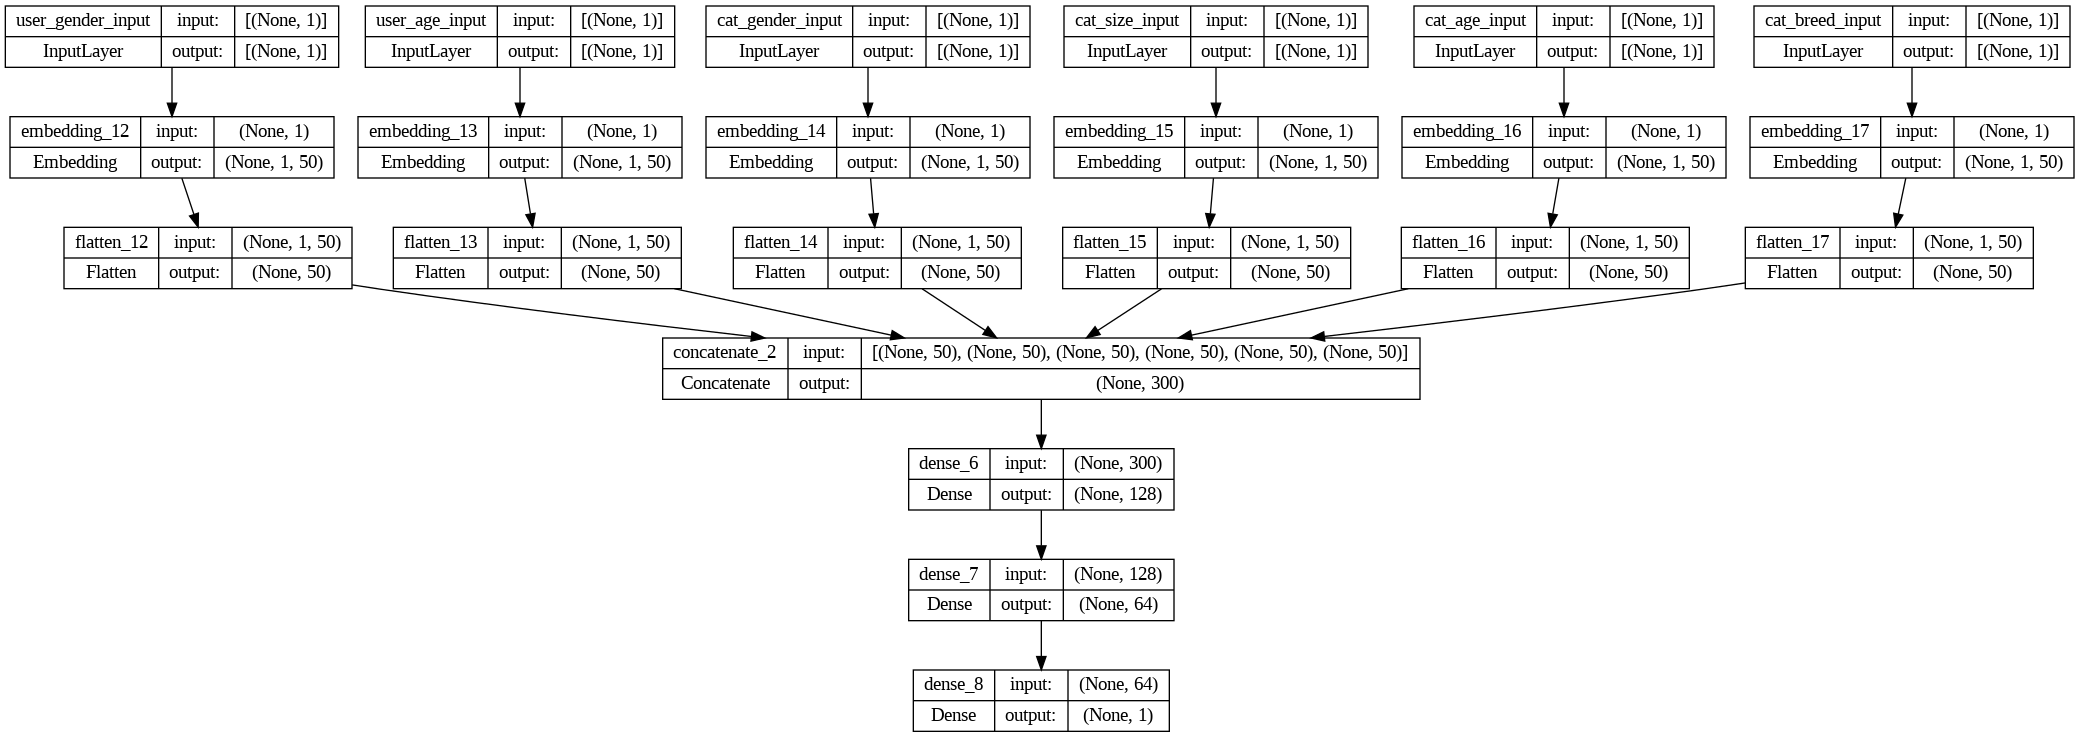

In [86]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_summary.png', show_shapes=True)

In [87]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [88]:
# Train the model
history = model.fit(
    x=[train_df['user_gender'], train_df['user_age'], train_df['cat_gender'], train_df['cat_size'], train_df['cat_age'],train_df['cat_breed']],
    y=train_df['cat_rating'],
    epochs=1000,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 0.9392 - val_loss: 0.8944
Epoch 2/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.8739 - val_loss: 0.7886
Epoch 3/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.7498 - val_loss: 0.6375
Epoch 4/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.5726 - val_loss: 0.4454
Epoch 5/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.4026 - val_loss: 0.3220
Epoch 6/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3507 - val_loss: 0.2589
Epoch 7/1000
1/1 [==============================] - 0s 84ms/step - loss: 0.3122 - val_loss: 0.2095
Epoch 8/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.2827 - val_loss: 0.2000
Epoch 9/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.2665 - val_loss: 0.2000
Epoch 10/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.2533 - val_loss: 0.2000
Epoch 11/10

In [89]:
# Evaluate the model on the test set
test_loss = model.evaluate(
    x=[test_df['user_gender'], test_df['user_age'], test_df['cat_gender'], test_df['cat_size'], test_df['cat_age'], test_df['cat_breed']],
    y=test_df['cat_rating']
)

print(f'Test Loss: {test_loss}')

1/1 [==============================] - 0s 37ms/step - loss: 0.1670
Test Loss: 0.1670234054327011


### Make predictions for users

In [92]:
def collaborative_filtering_recommendation(model, encoders, user_gender, user_age, cat_gender, cat_age, cat_size, cat_breed, top_n=5, similarity_threshold=0.5):
    # Load encoders
    user_gender_encoder = encoders['user_gender_encoder']
    user_age_encoder = encoders['user_age_encoder']
    cat_gender_encoder = encoders['cat_gender_encoder']
    cat_size_encoder = encoders['cat_size_encoder']
    cat_age_encoder = encoders['cat_age_encoder']
    cat_breed_encoder = encoders['cat_breed_encoder']

    # Encode input features
    try:
        user_gender_encoded = user_gender_encoder.transform([user_gender])[0]
        user_age_encoded = user_age_encoder.transform([user_age])[0]
        cat_gender_encoded = cat_gender_encoder.transform([cat_gender])[0]
        cat_size_encoded = cat_size_encoder.transform([cat_size])[0]
        cat_age_encoded = cat_age_encoder.transform([cat_age])[0]
        cat_breed_encoded = cat_breed_encoder.transform([cat_breed])[0]
    except ValueError as e:
        # Handle unseen labels (e.g., assign a default value or skip the data point)
        print(f"Error: {e}")
        return None

    # Make predictions for the user's preferences
    user_preferences = model.predict([
        np.array([user_gender_encoded]),
        np.array([user_age_encoded]),
        np.array([cat_gender_encoded]),
        np.array([cat_size_encoded]),
        np.array([cat_age_encoded]),
        np.array([cat_breed_encoded])
    ])

    # Find users with predicted ratings close to the user's rating
    similar_users = df.loc[
        (df['cat_rating'] >= user_preferences[0][0] - similarity_threshold) & (df['cat_rating'] <= user_preferences[0][0] + similarity_threshold)
    ]

    # Sort similar users by rating and select the top N users
    top_users = similar_users.sample(min(top_n, len(similar_users)))

    # Extract recommended cat IDs from the top users
    recommended_cat_ids = top_users['cat_id'].tolist()

    return recommended_cat_ids

In [109]:
# Example of how to use the recommendation function
user_id_input='1'
user_gender_input = "Male"
user_age_input = "25"
cat_gender_input = "male"
cat_size_input = "medium"
cat_age_input = "Adult"
cat_breed_input = "local"

recommended_cats = collaborative_filtering_recommendation(model, encoders, user_gender_input, user_age_input, cat_gender_input, cat_age_input, cat_size_input, cat_breed_input)


print(f'Recommended Cat IDs: {recommended_cats}')

1/1 [==============================] - 0s 28ms/step
Recommended Cat IDs: [0, 22, 8, 26, 12]


### Save Model

In [104]:
model.save("Kucingku_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **LOAD MODEL FOR TEST**

In [ ]:
from tensorflow.keras.models import load_model

In [105]:

# Load the model
loaded_model = load_model("Kucingku_model.h5")  # Replace with your actual model path

# Evaluate the loaded model on the test set
test_loss = loaded_model.evaluate(
    x=[test_df['user_gender'], test_df['user_age'], test_df['cat_gender'], test_df['cat_size'], test_df['cat_age'], test_df['cat_breed']],
    y=test_df['cat_rating']
)

print(f'Test Loss: {test_loss}')


1/1 [==============================] - 0s 441ms/step - loss: 0.1670
Test Loss: 0.1670234054327011


# **Menjadikan tflite**

In [106]:
# Load the Keras model
keras_model = load_model("Kucingku_model.h5")  # Replace with your actual model path

# Convert the Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open("Kucingku_model.tflite", "wb") as f:
    f.write(tflite_model)
